
✅ 精简模型 R²: 0.709, MSE: 37373.44

🎯 精简模型的特征重要性：
             Feature  Importance
0             Income    0.595452
3    NumWebPurchases    0.092961
2         TotalSpent    0.089142
1  NumStorePurchases    0.087021
4                Age    0.048860
5            Recency    0.045875
6  NumDealsPurchases    0.020625
7      Education_PhD    0.020065


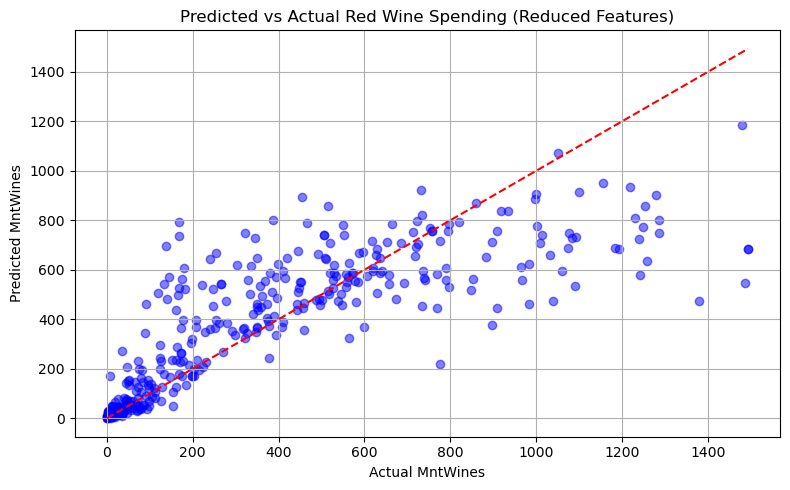

交叉验证 R² 分数： [0.75323106 0.66679206 0.69485004 0.68995586 0.68946904]
平均 R²：0.699


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# === 预处理部分（略） ===
df = pd.read_csv('marketing_campaign_NEW.csv', sep='\t')
df['Age'] = 2025 - df['Year_Birth']
df = df[df['Age'] <= 100]
df = df.dropna(subset=['Income'])
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)
df['TotalSpent'] = df[[
    'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)
features = [
    'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency',
    'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases',
    'TotalSpent'
] + [col for col in df.columns if col.startswith('Education_') or col.startswith('Marital_Status_')]
target = 'MntWines'
# 设置过滤阈值
Setting_Amount = 0  # 你可以改成 100、200 等

# 计算总消费（包括 MntWines）
df['TotalSpendingAll'] = df[[
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)

# 筛选出活跃客户（消费额大于 Setting_Amount）
df_active = df[df['TotalSpendingAll'] >= Setting_Amount].copy()
# 替代原本的 df --> df_active 后进行建模
X = df_active[features]
y = df_active[target]


# 假设你已经有了 X, y（模型用的原始特征与目标变量）

# 👉 第一步：用原始数据训练一次，提取 feature importance
rf_init = RandomForestRegressor(n_estimators=100, random_state=42)
rf_init.fit(X, y)

# 👉 第二步：按重要性筛选特征（可调节阈值）
importances = rf_init.feature_importances_
features_all = X.columns
coef_table = pd.DataFrame({
    "Feature": features_all,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 设置阈值，只保留重要性 > 0.01 的特征
important_features = coef_table[coef_table['Importance'] > 0.01]['Feature'].tolist()
X_reduced = X[important_features]

# 👉 第三步：重新训练随机森林模型
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 👉 第四步：评估模型性能
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"\n✅ 精简模型 R²: {r2:.3f}, MSE: {mse:.2f}")

# 👉 第五步：输出新模型的特征重要性表
coef_reduced = pd.DataFrame({
    "Feature": X_reduced.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n🎯 精简模型的特征重要性：")
print(coef_reduced)

# 👉 第六步：画出预测 vs 实际散点图
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual MntWines")
plt.ylabel("Predicted MntWines")
plt.title("Predicted vs Actual Red Wine Spending (Reduced Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 👉 第七步：交叉验证
cv_scores = cross_val_score(rf_model, X_reduced, y, cv=5, scoring='r2')
print("交叉验证 R² 分数：", cv_scores)
print(f"平均 R²：{cv_scores.mean():.3f}")
